<a href="https://colab.research.google.com/github/karam-koujan/dog-vs-cat-classification/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-06-25 14:08:05--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-06-25 14:08:06--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-06-25 14:08:06--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [4]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted([
    os.path.join(input_dir,fname)
   for fname in os.listdir(input_dir)
   if fname.endswith(".jpg")
])
target_img_paths = sorted([
    os.path.join(target_dir,fname)
   for fname in os.listdir(target_dir)
   if fname.endswith(".png") and not fname.startswith(".")
])

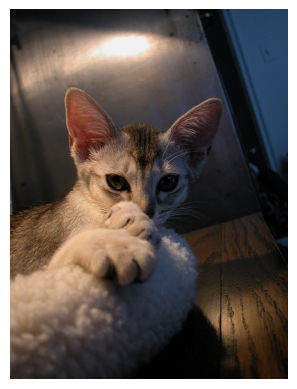

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")

plt.imshow(load_img(input_img_paths[1]))


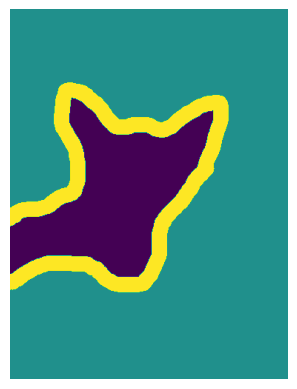

In [6]:
def display_target(target_array) :
   normalized_array = (target_array.astype("uint8") - 1) * 127
   plt.axis("off")
   plt.imshow(normalized_array[:,:,0])

img = img_to_array(load_img(target_img_paths[1],color_mode="grayscale"))
display_target(img)

In [7]:
import numpy as np
import random
img_size = (200,200)
num_imgs = len(input_img_paths)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
def path_to_input_image(path):
    return img_to_array(load_img(path,target_size=img_size))
def path_to_target(path):
     img =  img_to_array(load_img(path,target_size=img_size, color_mode="grayscale"))
     img = img.astype("uint8") - 1
     return img
input_imgs = np.zeros((num_imgs,)+img_size+(3,),dtype="float32")
targets = np.zeros((num_imgs,)+img_size+(1,),dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_img_paths[i])
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets =   targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets =   targets[-num_val_samples:]

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size,num_classes):
   inputs = keras.Input(shape = img_size + (3,))
   x = layers.Rescaling(1./255)(inputs)
   x = layers.Conv2D(64,3,strides=2,activation="relu",padding="same")(x)
   x = layers.Conv2D(64,3,activation="relu",padding="same")(x)
   x = layers.Conv2D(128,3,strides=2,activation="relu",padding="same")(x)
   x = layers.Conv2D(128,3,activation="relu",padding="same")(x)
   x = layers.Conv2D(256,3,strides=2,activation="relu",padding="same")(x)
   x = layers.Conv2D(256,3,activation="relu",padding="same")(x)

   x = layers.Conv2DTranspose(256,3,activation="relu",padding="same")(x)
   x = layers.Conv2DTranspose(256,3,activation="relu",padding="same",strides=2)(x)

   x = layers.Conv2DTranspose(128,3,activation="relu",padding="same")(x)
   x = layers.Conv2DTranspose(128,3,activation="relu",padding="same",strides=2)(x)

   x = layers.Conv2DTranspose(64,3,activation="relu",padding="same")(x)
   x = layers.Conv2DTranspose(64,3,activation="relu",padding="same",strides=2)(x)

   outputs = layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)
   model = keras.Model(inputs,outputs)
   return model
model = get_model(img_size=img_size,num_classes = 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [12]:
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)
]
history = model.fit(train_input_imgs,train_targets,epochs=50,callbacks=callbacks,batch_size=64,validation_data=(val_input_imgs ,val_targets))

Epoch 1/50
 75/100 [=====================>........] - ETA: 22:20 - loss: 0.9516

KeyboardInterrupt: ignored

In [ ]:
loss  = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title("Training and validation loss")
plt.legend()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]
def display_mask(pred):
   mask = np.argmax(pred, axis=-1)
mask *= 127
plt.axis("off")
plt.imshow(mask)
display_mask(mask)